In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision import datasets
import clip
import cv2
from PIL import Image

In [2]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
# 加载ResNet模型
clip_model, _ = clip.load("RN50", device="cuda:0")
clip_model = clip_model.to(torch.float)
resnet = clip_model.visual

d:\Anaconda3\envs\pytorch-gpu\lib\site-packages\clip\clip.py:57: UserWarning: C:\Users\Matt/.cache/clip\RN50.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|████████████████████████████████████████| 244M/244M [18:48<00:00, 227kiB/s]


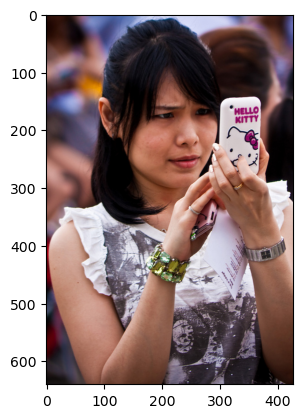

In [173]:
img_path = r"H:\Code\AutoDL_backup\datasets\image_caption_generation\COCO2017\val2017\000000001296.jpg"
# plt show
plt.imshow(plt.imread(img_path))

In [233]:
print(resnet)

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

In [67]:
def resize_heatmap_to_image(feature_map, image_shape):
    """
    Resize feature map to match the original image size.

    Args:
        feature_map (torch.Tensor or np.ndarray): The feature map from a CNN layer.
        image_shape (tuple): The original image shape (H, W).

    Returns:
        np.ndarray: Resized feature map.
    """
    if isinstance(feature_map, torch.Tensor):
        feature_map = feature_map.cpu().detach().numpy()

    resized_heatmap = cv2.resize(feature_map, (image_shape[1], image_shape[0]))
    return resized_heatmap

In [68]:
def overlay_heatmap_on_image(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay the attention heatmap on the original image.
    
    Args:
        image (PIL.Image or np.ndarray): The original image.
        heatmap (torch.Tensor or np.ndarray): The attention heatmap.
        alpha (float): Transparency factor for blending heatmap.
        colormap (int): OpenCV colormap.
    
    Returns:
        np.ndarray: Image with the heatmap overlay.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().detach().numpy()
    
    # Normalize and resize heatmap
    heatmap = resize_heatmap_to_image(heatmap, image.shape[:2])
    heatmap = np.uint8(255 * heatmap / np.max(heatmap))
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Convert image to uint8 if necessary
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    
    # Blend heatmap with image
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_image

In [86]:
def visualize_attention(image, feature_map, alpha=0.5, save_path="heatmap.pdf"):
    """
    Visualizes the heatmap overlay on the image and saves it as a PDF.

    Args:
        image (PIL.Image or np.ndarray): The original image.
        feature_map (torch.Tensor or np.ndarray): The CNN feature map.
        alpha (float): Transparency factor.
        save_path (str): Path to save the output PDF.
    """
    heatmap = resize_heatmap_to_image(feature_map, image.shape[:2])
    overlayed_image = overlay_heatmap_on_image(image, heatmap, alpha)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlayed_image)
    plt.axis("off")

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap="jet")
    sm.set_array([])
    plt.colorbar(sm, fraction=0.046, pad=0.04)

    plt.savefig(save_path, format="pdf", bbox_inches="tight", pad_inches=0)
    
    # plt.close()

In [236]:
# 获取目标层
# target_layer = resnet.layer4[2].conv3  # 选择layer4的一部分作为示例
target_layer = resnet.attnpool

# 准备输入图像
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img = datasets.folder.default_loader(
    img_path,
)  # 替换为你的图片路径
img = transform(img).unsqueeze(0)  # 增加batch维度

In [245]:
# # 用来存储梯度
# gradients = []
# features = []


# def save_gradient(grad):
#     gradients.append(grad)


# def save_features(module, input, output):
#     features.append(output)
#     output.register_hook(save_gradient)  # 记录梯度


# # 注册钩子
# target_layer = resnet.layer3[2].conv3  # 选择目标层
# hook = target_layer.register_forward_hook(save_features)

# # 处理输入图像
# transform = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )

# img = transforms.ToPILImage()(torch.rand(3, 224, 224))  # 示例图像
# img = transform(img).unsqueeze(0).to("cuda:0")  # 增加batch维度

# # 前向传播
# output = resnet(img)
# pred_class = output.argmax(dim=1)

# # 计算梯度
# resnet.zero_grad()
# output[:, pred_class].backward()

# # 获取梯度和特征图
# grads = gradients[0].detach().cpu().numpy()
# feature_map = features[0].detach().cpu().numpy()[0]

# # 计算Grad-CAM
# weights = np.mean(grads, axis=(2, 3))  # 计算全局平均池化
# cam = np.sum(weights[:, :, np.newaxis, np.newaxis] * feature_map, axis=0)
# cam = np.maximum(cam, 0)  # ReLU操作
# cam = cv2.resize(cam, (224, 224))
# cam = cam - np.min(cam)
# cam = cam / (np.max(cam) + 1e-8)  # Avoid division by zero
# cam = np.clip(cam * 255, 0, 255).astype(np.uint8)  # Ensure valid range and type

# if len(cam.shape) == 3:  # Ensure it's a 2D grayscale image
#     cam = np.mean(cam, axis=0).astype(np.uint8)

# # 叠加到原始图像
# original_image = img.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert to HWC format
# original_image = (original_image - original_image.min()) / (
#     original_image.max() - original_image.min()
# )  # Normalize to [0,1]
# original_image = (original_image * 255).astype(np.uint8)  # Convert to uint8

# heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Ensure it's a 3-channel color map

# if heatmap.shape[:2] != original_image.shape[:2]:  # Ensure same dimensions
#     heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

# # Convert original image to 3-channel if needed
# if len(original_image.shape) == 2:  # Grayscale image
#     original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# # Blend images
# overlayed_image = cv2.addWeighted(original_image, 0.7, heatmap, 0.3, 0)

# # overlayed_image = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

# # 显示结果
# plt.figure(figsize=(6, 6))
# plt.imshow(overlayed_image)
# plt.axis("off")
# plt.colorbar()
# plt.show()

# # 释放钩子
# hook.remove()

ValueError: operands could not be broadcast together with shapes (1,2048,1,1) (1024,14,14) 

In [235]:
# # 定义Grad-CAM钩子函数
# gradients = []


# def save_gradient(grad):
#     gradients.append(grad)

# 用来存储钩子输出
features = []

# 钩子函数，保存特征图
def save_features(module, input, output):
    features.append(output)


# 注册钩子
hook = target_layer.register_forward_hook(save_features)

# 准备输入图像
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img = transforms.ToPILImage()(torch.rand(3, 224, 224))  # 示例图像
img = transform(img).unsqueeze(0)  # 增加batch维度

# 前向传播
output = resnet(img.to("cuda:0"))

# 解除钩子
hook.remove()

print(len(features))

# 可视化特征图（降维操作）
feature_map = features[0].squeeze(0).detach().cpu().numpy()
print("feature_map.shape: ", feature_map.shape)  # 输出特征图的形状
# 通过最大池化对所有通道进行池化，降维为一个2D图像
# max_pool_map = feature_map.max(axis=0)  # 对所有通道进行最大池化

print(feature_map[0, :, :].shape)

mean_feature_map = np.mean(feature_map, axis = 0)
print("mean_feature_map.shape: ", mean_feature_map.shape)

max_feature_map = np.max(feature_map, axis = 0)
print("max_feature_map.shape: ", max_feature_map.shape)

min_feature_map = np.min(feature_map, axis = 0)
print("min_feature_map.shape: ", min_feature_map.shape)

# 展示mean_feature_map和max_feature_map
plt.subplot(1, 3, 1)
plt.imshow(mean_feature_map, cmap="jet")  # 显示第一个通道的特征图
plt.axis("off")  # 关闭坐标轴
plt.subplot(1, 3, 2)
plt.imshow(max_feature_map, cmap="jet")  # 显示第一个通道的特征图
plt.axis("off")  # 关闭坐标轴
plt.subplot(1, 3, 3)
plt.imshow(min_feature_map, cmap="jet")  # 显示第一个通道的特征图
plt.show()

# # 选择第一个通道的特征图进行可视化
# plt.imshow(mean_feature_map, cmap="jet")  # 显示第一个通道的特征图
# plt.axis("off")  # 关闭坐标轴
# plt.show()

1
feature_map.shape:  (1024,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [228]:
original_imge = Image.open(img_path)

In [229]:
print(original_imge)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x640 at 0x20CF24DDBE0>


In [230]:
arr_img = np.array(original_imge)

In [231]:
print(arr_img.shape)

(640, 427, 3)


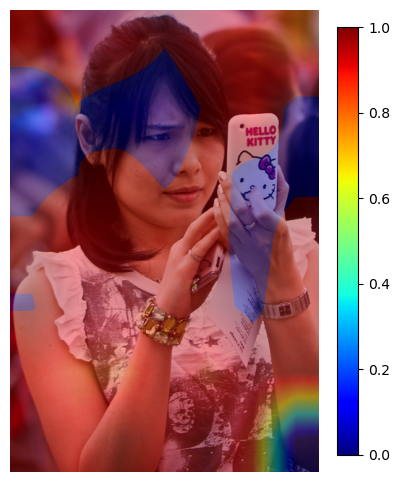

In [232]:
visualize_attention(arr_img, mean_feature_map, alpha=0.4, save_path="../plot/figs/heatmap/rn50_layer4_mean_feature_map_v2.pdf")